### Basic Checks

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/wind-turbines-data-csv/Data.csv


In [2]:
df=pd.read_csv("/kaggle/input/wind-turbines-data-csv/Data.csv")

In [3]:
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [4]:
df.shape

(9568, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,9568.0,19.651231,7.452473,1.81,13.5100,20.345,25.72,37.11
V,9568.0,54.305804,12.707893,25.36,41.7400,52.080,66.54,81.56
AP,9568.0,1013.259078,5.938784,992.89,1009.1000,1012.940,1017.26,1033.30
RH,9568.0,73.308978,14.600269,25.56,63.3275,74.975,84.83,100.16
PE,9568.0,454.365009,17.066995,420.26,439.7500,451.550,468.43,495.76


In [7]:
df.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(41)

In [9]:
df.columns

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

### EDA

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

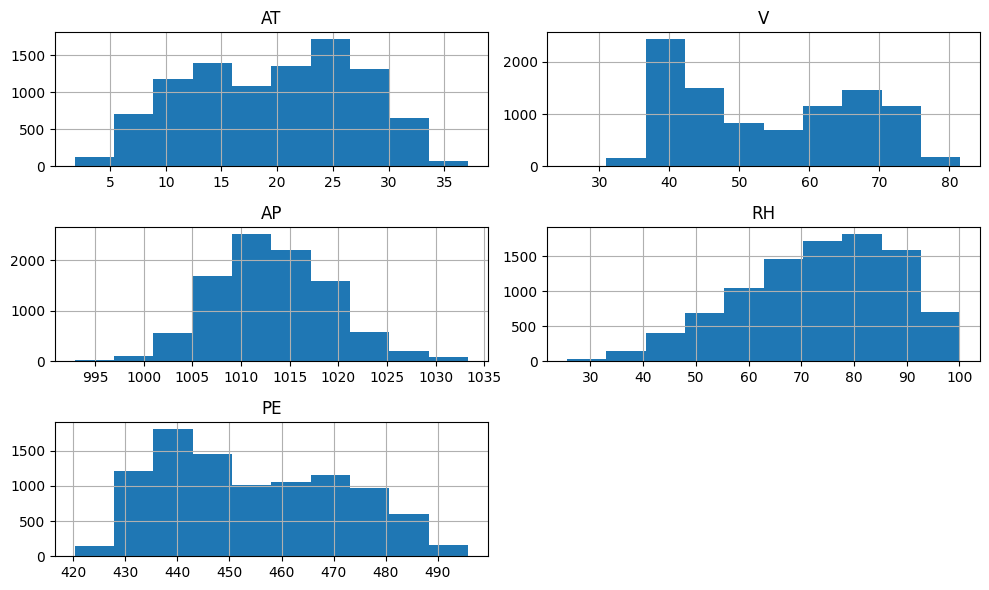

In [11]:
df.hist(figsize=(10,6))
plt.title("Distribution of Features")
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

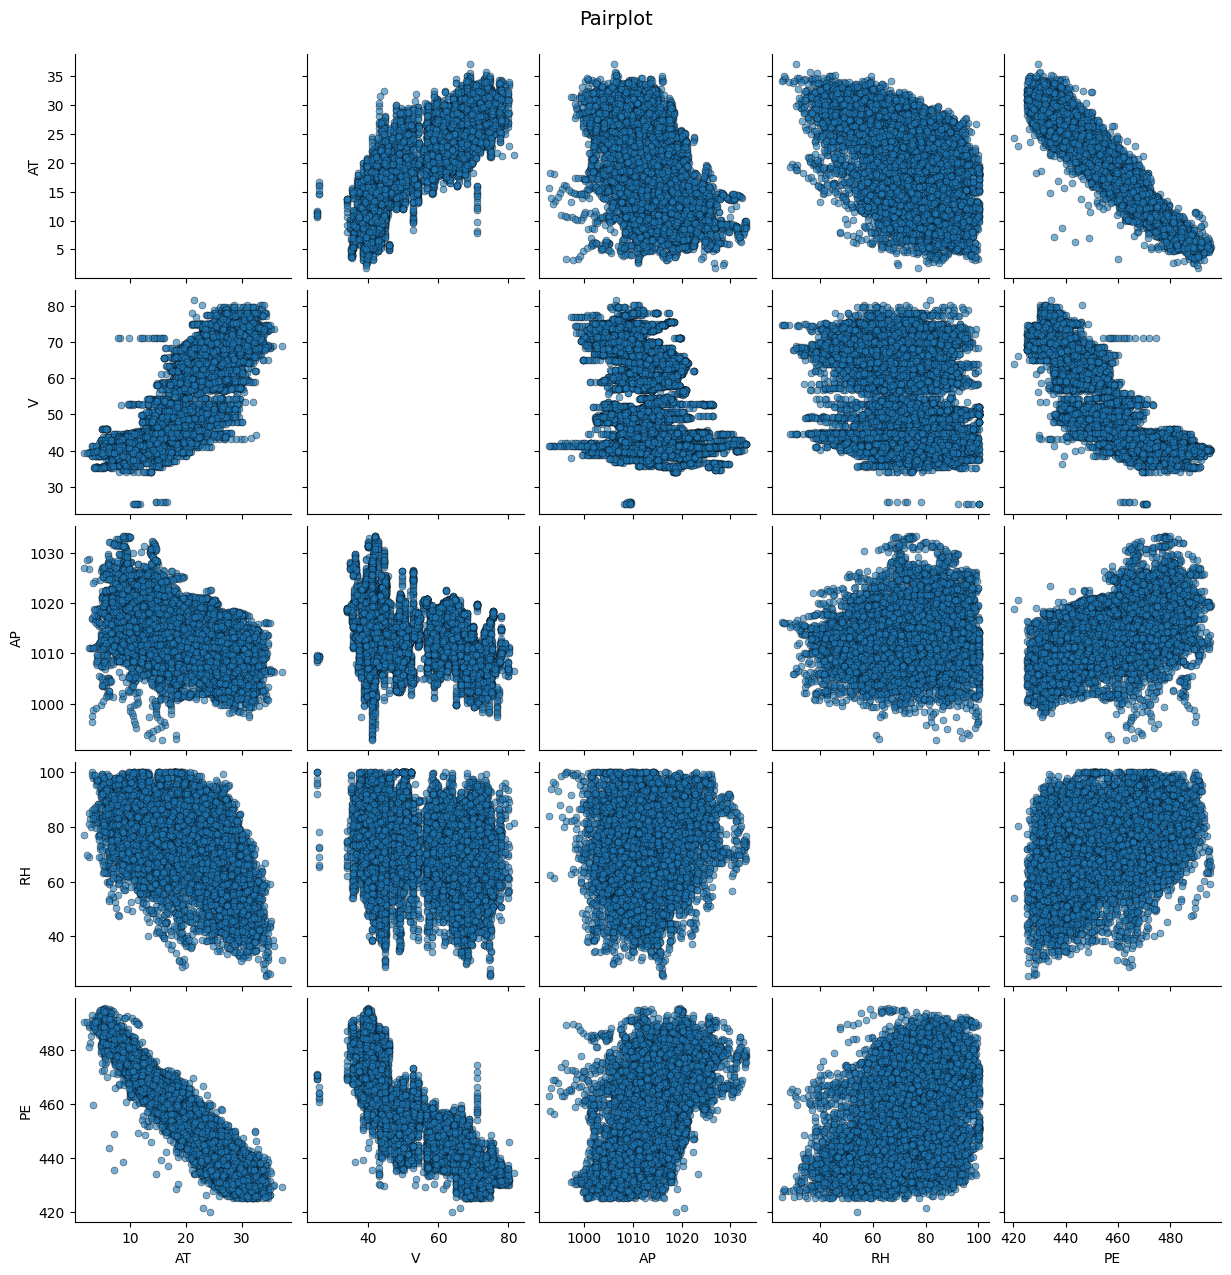

In [12]:
plt.figure(figsize=(10,8))
sns.pairplot(df,kind='scatter',diag_kind=True,plot_kws={"alpha":0.6,"s":25,"edgecolor":"k"},diag_kws={"shade":True,"bw_adjust":1.2})
plt.suptitle("Pairplot",fontsize=14,y=1.02)
plt.show()

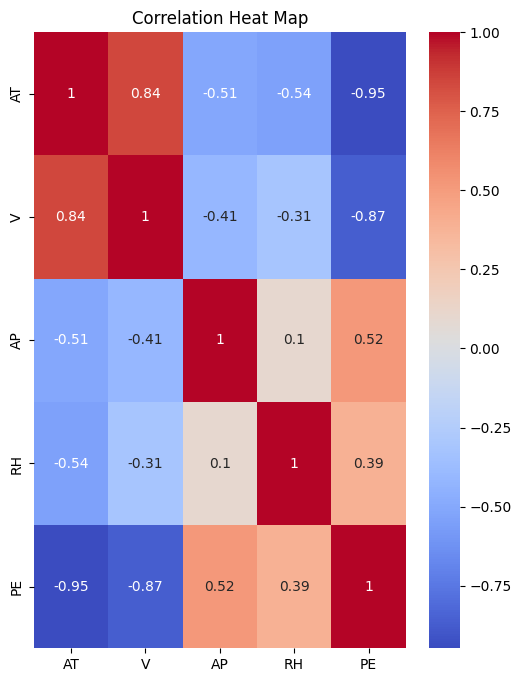

In [13]:
plt.figure(figsize=(6,8))
sns.heatmap(df.corr(),annot=True,cmap="coolwarm")
plt.title("Correlation Heat Map")
plt.show()

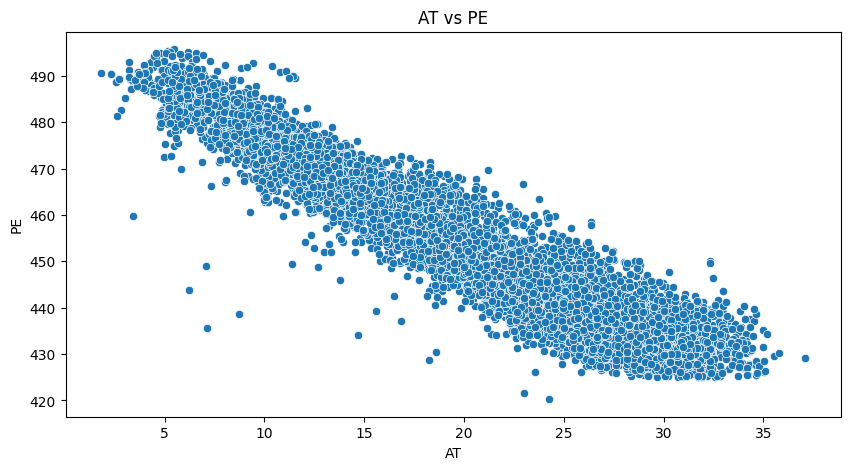

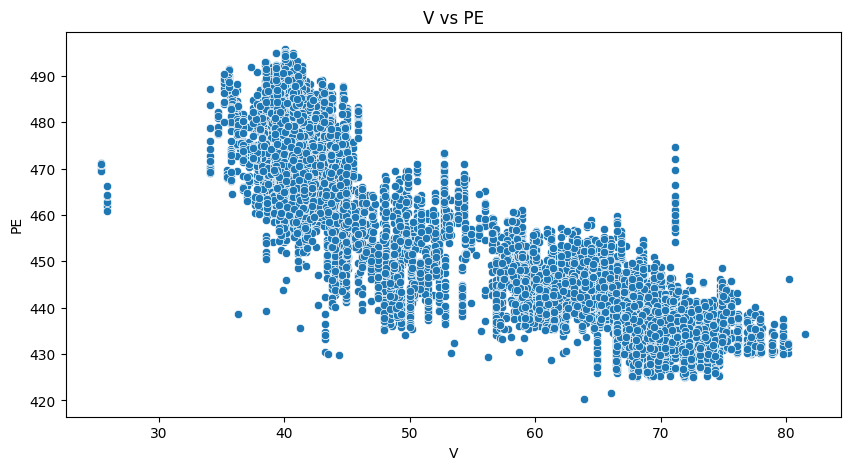

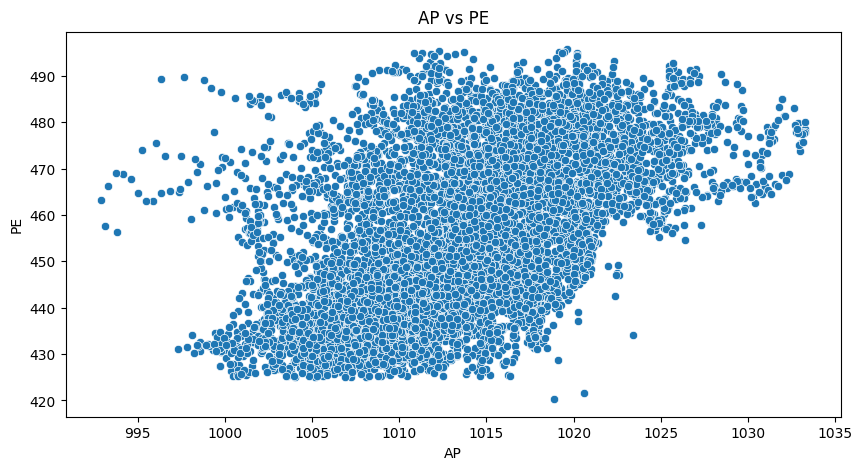

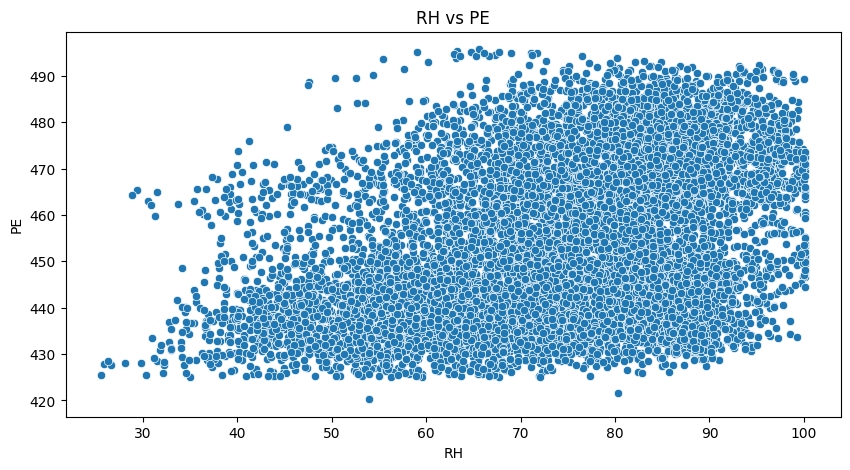

In [14]:
for col in df.columns:
    if col!='PE':
        plt.figure(figsize=(10,5))
        sns.scatterplot(x=df[col],y=df['PE'])
        plt.title(f'{col} vs PE')
        plt.show()
    else:
        pass

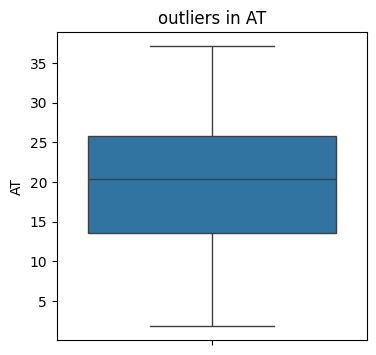

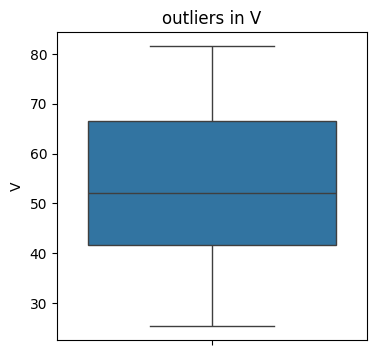

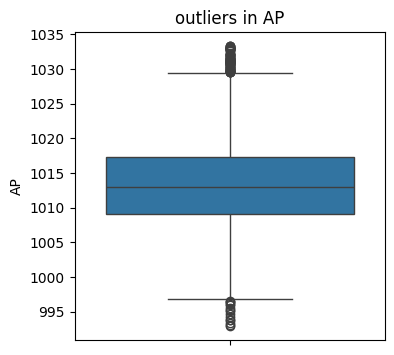

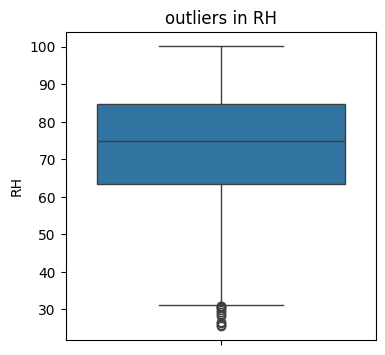

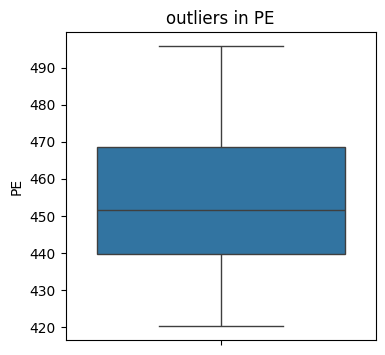

In [15]:
for col in df.columns:
    plt.figure(figsize=(4,4))
    sns.boxplot(df[col])
    plt.title(f"outliers in {col}")
    plt.show()

### Working on Outliers

In [16]:
q1 = df['AP'].quantile(0.25)
q3 = df['AP'].quantile(0.75)

iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

df['AP'] = np.where(df['AP'] < lower, lower,np.where(df['AP'] > upper, upper, df['AP']))

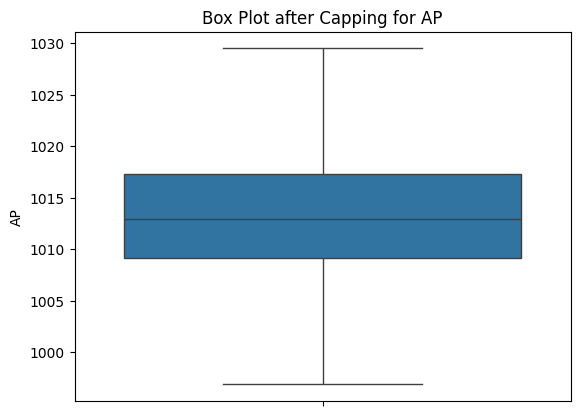

In [17]:
sns.boxplot(df['AP'])
plt.title("Box Plot after Capping for AP")
plt.show()

In [18]:
q1_RH=df['RH'].quantile(0.25)
q3_RH=df['RH'].quantile(0.75)

iqr_RH=q3_RH-q1_RH

lower_RH=q1_RH-1.5*iqr_RH

df['RH']=np.where(df['RH']<lower_RH,lower_RH,df['RH'])

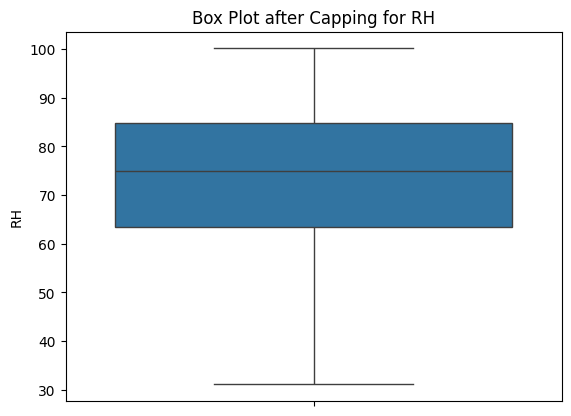

In [19]:
sns.boxplot(df['RH'])
plt.title("Box Plot after Capping for RH")
plt.show()

### Model Training and Testing

In [20]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df.drop('PE',axis=1),df['PE'],test_size=0.2,random_state=42)

In [21]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [22]:
model_xg=XGBRegressor(n_estimators=2000,learning_rate=0.09,max_depth=4,subsample=0.9,colsample_bytree=0.9,reg_lambda=1,random_state=42)
model_xg.fit(X_train,y_train)

y_pred_xg=model_xg.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test,y_pred_xg))
mae=mean_absolute_error(y_test,y_pred_xg)
r2=r2_score(y_test,y_pred_xg)

print("RMSE of XGBoost:", rmse)
print("MAE of XGBoost :", mae)
print("R² of XGBoost :", r2)

RMSE of XGBoost: 2.954240823548472
MAE of XGBoost : 2.1133977327575995
R² of XGBoost : 0.9699110541754862


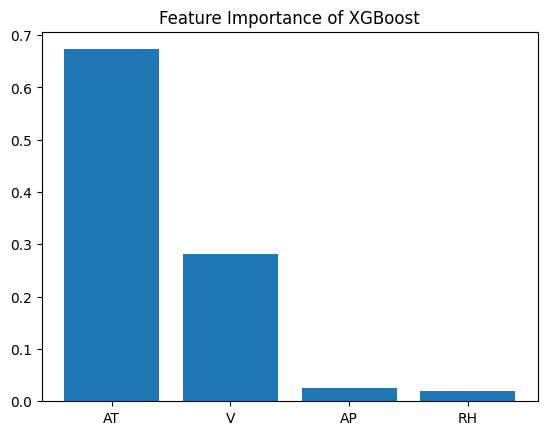

In [23]:
importance_xgb=model_xg.feature_importances_
plt.bar(df.drop('PE',axis=1).columns,importance_xgb)
plt.title("Feature Importance of XGBoost")
plt.show()

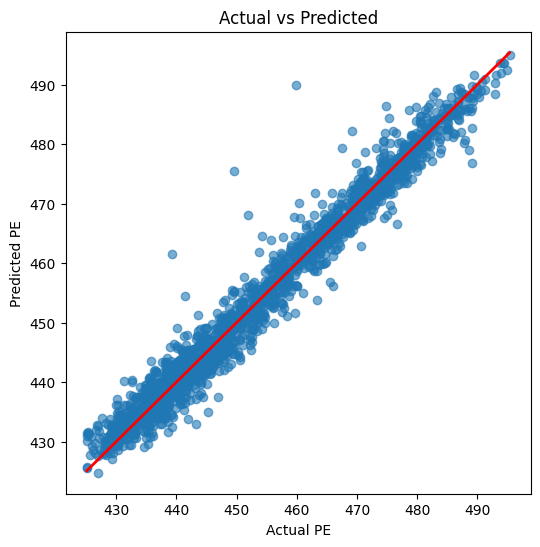

In [24]:
plt.figure(figsize=(6,6))
plt.scatter(y_test,y_pred_xg,alpha=0.6)
plt.xlabel("Actual PE")
plt.ylabel("Predicted PE")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],color='red',linewidth=2)
plt.show()

In [25]:
accuracy_xg=model_xg.score(X_test,y_test)
print("Accurcy of XGBoost :",accuracy_xg)

Accurcy of XGBoost : 0.9699110541754862


In [26]:
from sklearn.ensemble import RandomForestRegressor

model_rf=RandomForestRegressor(n_estimators=300,max_depth=None,random_state=42,n_jobs=-1)
model_rf.fit(X_train,y_train)

y_pred_rf=model_rf.predict(X_test)

rmse_rf=np.sqrt(mean_squared_error(y_test,y_pred_rf))
mae_rf=mean_absolute_error(y_test,y_pred_rf)
r2_rf=r2_score(y_test,y_pred_rf)

print("Random Forest Regression Metrics")
print("RMSE :",rmse_rf)
print("MAE :",mae_rf)
print("R2 Score :",r2_rf)

Random Forest Regression Metrics
RMSE : 3.229493850644618
MAE : 2.3138771856495963
R2 Score : 0.9640429457085125


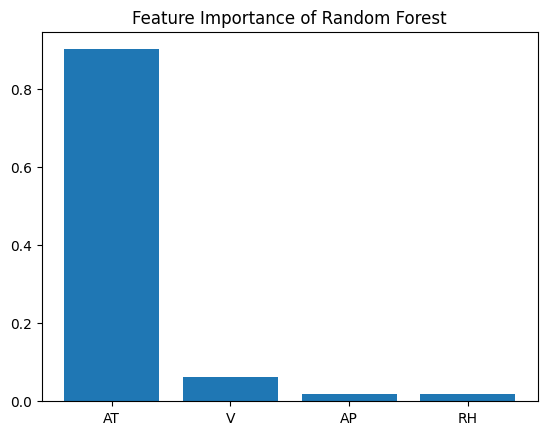

In [27]:
importance_rf=model_rf.feature_importances_
plt.bar(df.drop('PE',axis=1).columns,importance_rf)
plt.title("Feature Importance of Random Forest")
plt.show()

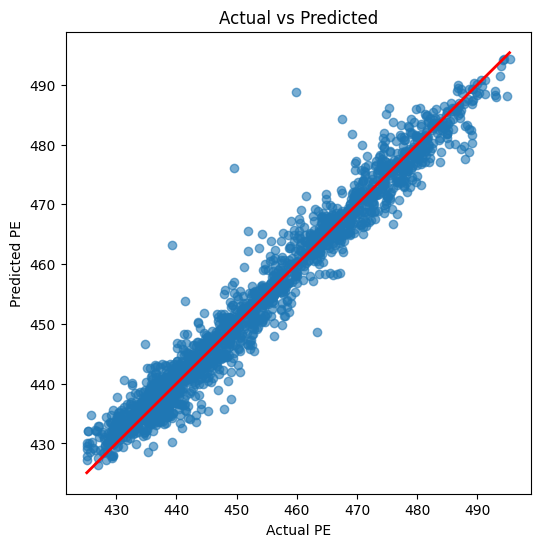

In [28]:
plt.figure(figsize=(6,6))
plt.scatter(y_test,y_pred_rf,alpha=0.6)
plt.xlabel("Actual PE")
plt.ylabel("Predicted PE")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],color='red',linewidth=2)
plt.show()

In [29]:
accuracy_rf=model_rf.score(X_test,y_test)
print("Accurcy of Random Forest :",accuracy_rf)

Accurcy of Random Forest : 0.9640429457085125
